In [21]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [4]:
df = pd.read_csv("training.csv")#.set_index("article_number")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9500 entries, 0 to 9499
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   article_number  9500 non-null   int64 
 1   article_words   9500 non-null   object
 2   topic           9500 non-null   object
dtypes: int64(1), object(2)
memory usage: 222.8+ KB


In [5]:
data = df[df.topic != "IRRELEVANT"].reset_index(drop=True)

In [10]:
obs_one = data.iloc[0,1].split(",")
print(obs_one)

['open', 'absent', 'cent', 'cent', 'cent', 'stock', 'inflow', 'rate', 'kim', 'end', 'forecast', 'won', 'won', 'won', 'won', 'won', 'myong', 'defend', 'dull', 'limit', 'limit', 'continu', 'continu', 'line', 'invest', 'bank', 'bank', 'bank', 'bank', 'bank', 'peg', 'tuesday', 'unwind', 'back', 'fear', 'due', 'move', 'move', 'foreign', 'foreign', 'wednesday', 'wednesday', 'wednesday', 'hwan', 'firm', 'firm', 'rise', 'level', 'today', 'today', 'dollar', 'dollar', 'dollar', 'dollar', 'dollar', 'dollar', 'dollar', 'dollar', 'belief', 'korean', 'intervent', 'deal', 'deal', 'deal', 'deal', 'buy', 'expect', 'suppl', 'suppl', 'posit', 'monday', 'fact', 'export', 'trad', 'trad', 'fresh', 'domest', 'clos', 'clos', 'clos', 'test', 'mid', 'sale', 'compar']


In [12]:
obs_four = data.iloc[3,1].split(",")
print(obs_four)

['open', 'forint', 'forint', 'forint', 'forint', 'cent', 'cent', 'stead', 'stead', 'dolar', 'end', 'takarebank', 'play', 'unit', 'budap', 'resist', 'resist', 'trend', 'made', 'bank', 'bank', 'rang', 'tuesday', 'shad', 'mark', 'mark', 'leav', 'wid', 'istv', 'finish', 'finish', 'percent', 'percent', 'percent', 'nbh', 'nbh', 'firm', 'hideg', 'level', 'level', 'dollar', 'dollar', 'dollar', 'dollar', 'basket', 'basket', 'basket', 'intervent', 'deal', 'market', 'trad', 'sell', 'start', 'float', 'reason', 'reason', 'clear', 'newsroom', 'dlr', 'futur', 'currenc', 'currenc', 'currenc', 'hung', 'hung', 'hung', 'compar']


The wording are incompeleted. You can see **trad**, **compar**, **currenc**

Some graphs about the numebr of words in each class

In [13]:
data['word_count'] = data.article_words.str.count(",")+1

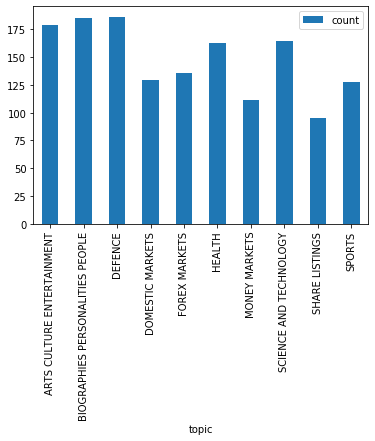

In [14]:
word_count_distribution = data.groupby("topic").word_count.mean().plot(kind="bar", label="count", legend="best")

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Text xticklabel objects>)

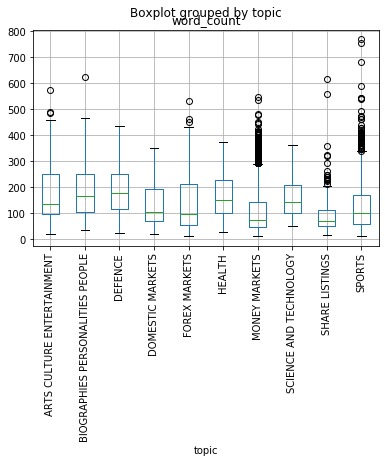

In [17]:
data.boxplot(column ='word_count',by ='topic')
plt.xticks(rotation=90)

Counting the most frequent five words in each class

In [27]:
topic_group = data.groupby('topic')
most_frequent_word_list = {}
for name, group in topic_group :
    frequent_words = Counter(" ".join(group["article_words"]).split(",")).most_common(5)
    most_frequent_word_list.update({name:frequent_words})


In [26]:
most_frequenst_word_list


{'ARTS CULTURE ENTERTAINMENT': [('year', 156),
  ('film', 153),
  ('million', 102),
  ('stat', 83),
  ('work', 81)],
 'BIOGRAPHIES PERSONALITIES PEOPLE': [('year', 249),
  ('presid', 198),
  ('yeltsin', 140),
  ('stat', 133),
  ('hospit', 124)],
 'DEFENCE': [('nato', 511),
  ('stat', 410),
  ('milit', 406),
  ('forc', 381),
  ('defend', 357)],
 'DOMESTIC MARKETS': [('import', 541),
  ('ton', 324),
  ('percent', 265),
  ('year', 262),
  ('oil', 191)],
 'FOREX MARKETS': [('dollar', 3358),
  ('bank', 2178),
  ('rate', 1720),
  ('trad', 1671),
  ('market', 1662)],
 'HEALTH': [('year', 253),
  ('health', 245),
  ('stat', 241),
  ('diseas', 184),
  ('tobacc', 169)],
 'MONEY MARKETS': [('bank', 4447),
  ('rate', 3684),
  ('percent', 3515),
  ('dollar', 3387),
  ('market', 2890)],
 'SCIENCE AND TECHNOLOGY': [('spac', 141),
  ('mir', 110),
  ('shuttl', 83),
  ('scient', 77),
  ('year', 73)],
 'SHARE LISTINGS': [('shar', 740),
  ('compan', 391),
  ('list', 347),
  ('million', 295),
  ('stock', 2